# Maximum Entropy (MaxEnt) species distribution modeling

## MaxEnt
[MaxEnt]((https://biodiversityinformatics.amnh.org/open_source/maxent/)) is a species distribution modeling (SDM) tool that uses a maximum entropy approach to model the probability of species occurrence. It is a general-purpose SDM tool that can be used to model the distribution of any species or group of species, and can be applied to any type of environmental data. MaxEnt is a Java application that can be run from the command line or from a graphical user interface (GUI)

## Sample Code

In [14]:
import matplotlib.pyplot as plt
import cartopy
import xarray as xr
import cartopy.crs as ccrs
import cmocean

### Open and plot environmental layers
- Check dimensions of data array
- Current layer: B-SOSE Dec. 31 2018 depth -55m
- Raw B-SOSE data to single layer code is in `sandbox.ipynb`

In [21]:
def so_ax():
  map_proj = ccrs.PlateCarree()
  fig = plt.figure(figsize=[10, 10])  # inches
  ax = plt.subplot(projection=map_proj)
  ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
  fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)
  return ax 

In [27]:
# Inspect salinity at time=10 (6 years x 12 months/year avg = 72 total) and depth = 25m
sal = xr.open_dataset('../../data/out/cnn_input_layers/salinity.nc')
sal['SALT']

<xarray.DataArray 'SALT' (YC: 588, XC: 2160)>
[1270080 values with dtype=float32]
Coordinates:
    iter     int64 ...
    time     datetime64[ns] ...
  * XC       (XC) float32 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float32 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72
    Z        float32 ...
    Depth    (YC, XC) float32 ...
    rA       (YC, XC) float32 ...
    drF      float32 ...
    hFacC    (YC, XC) float32 ...
Attributes:
    units:          psu
    long_name:      Salinity
    standard_name:  SALT

[]

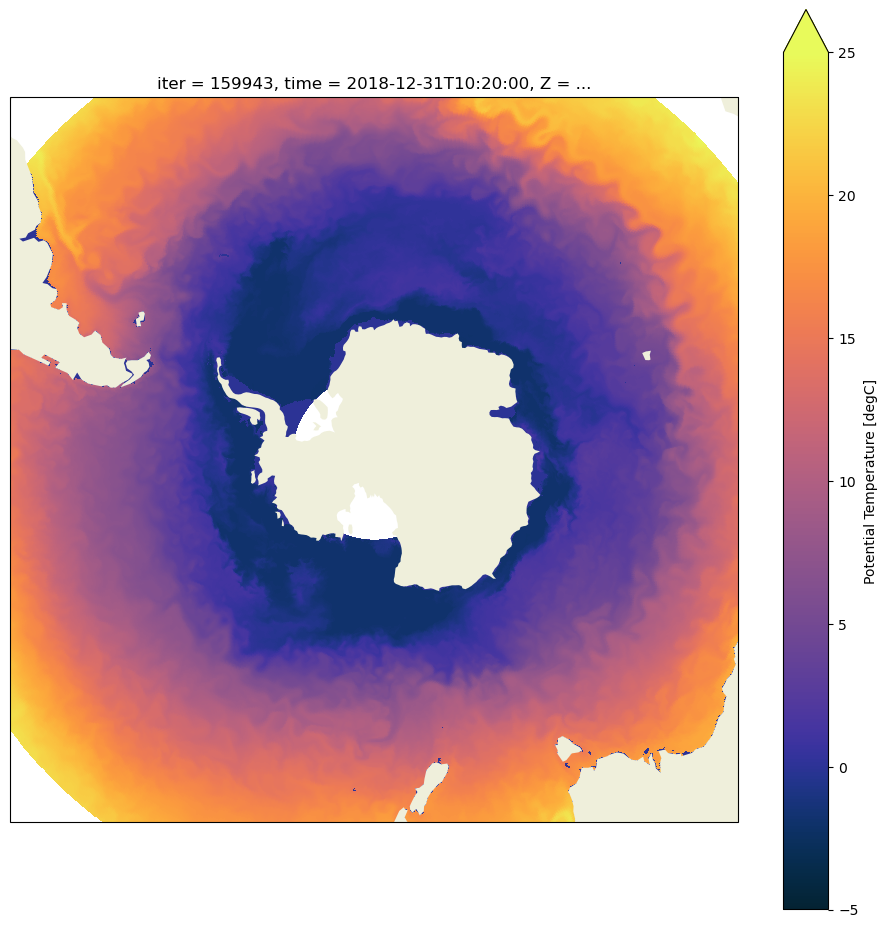

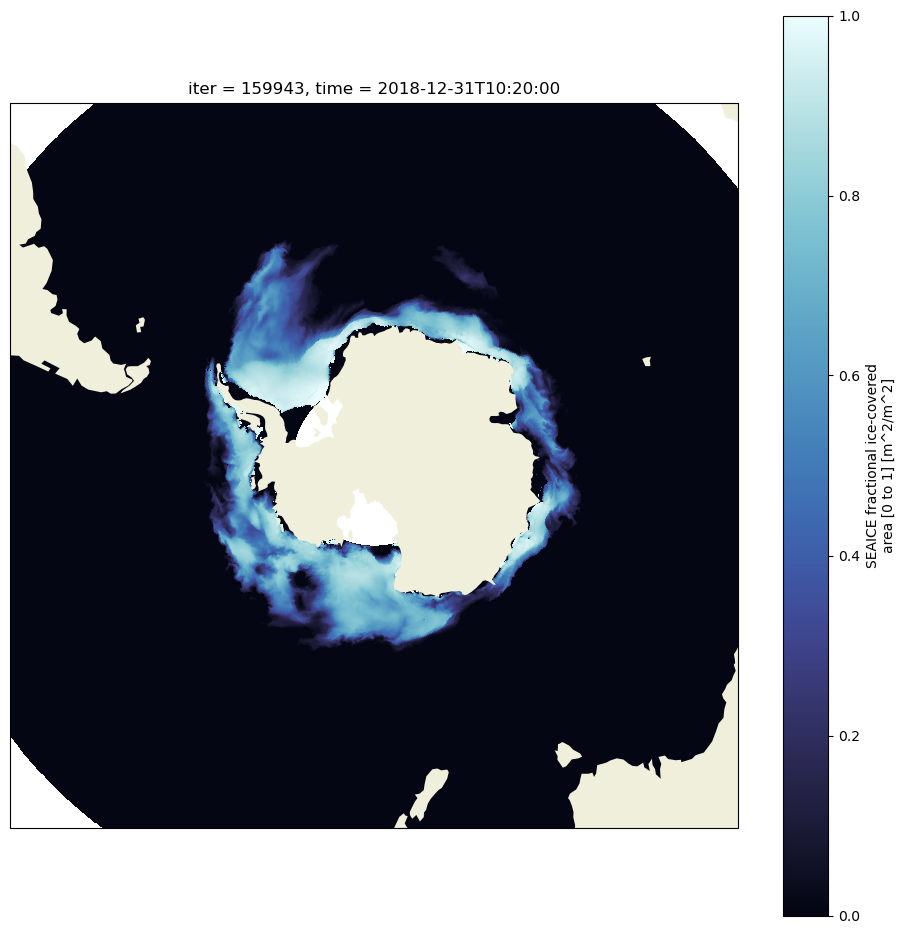

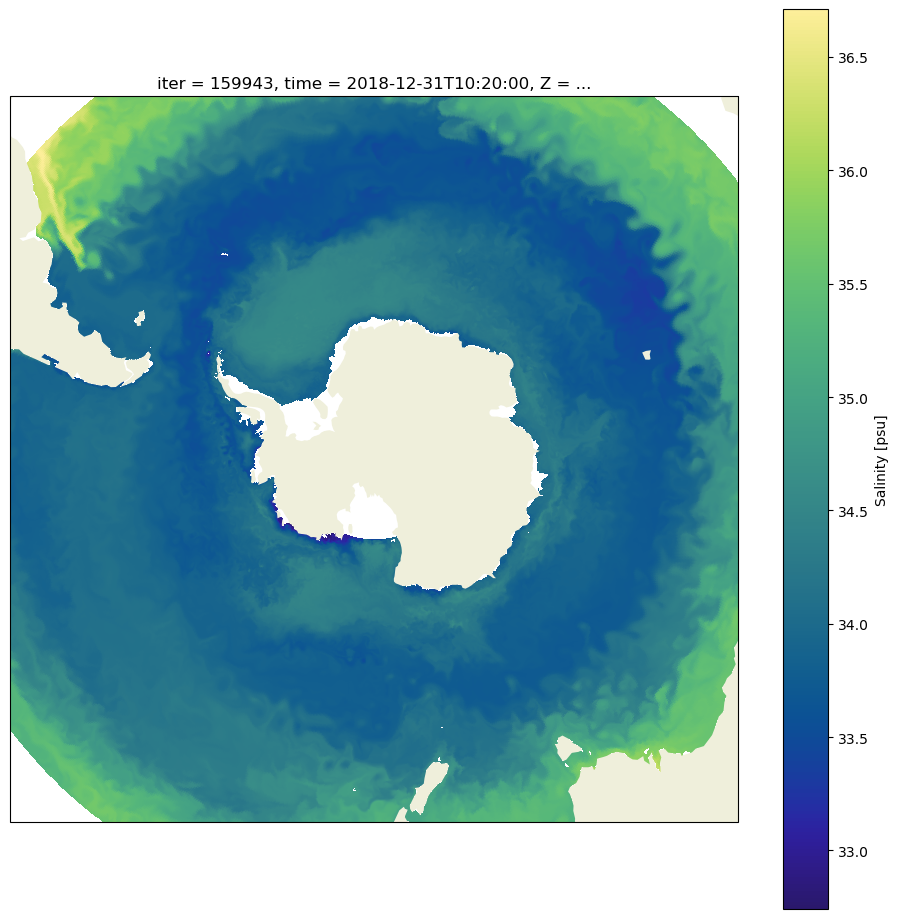

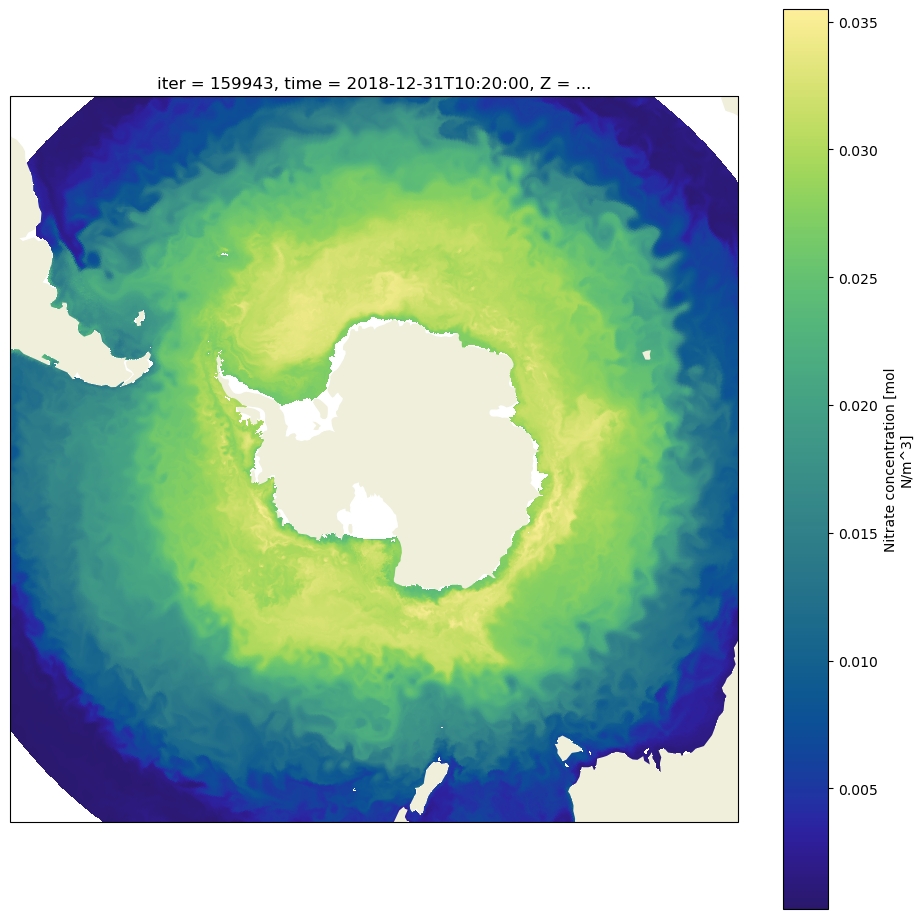

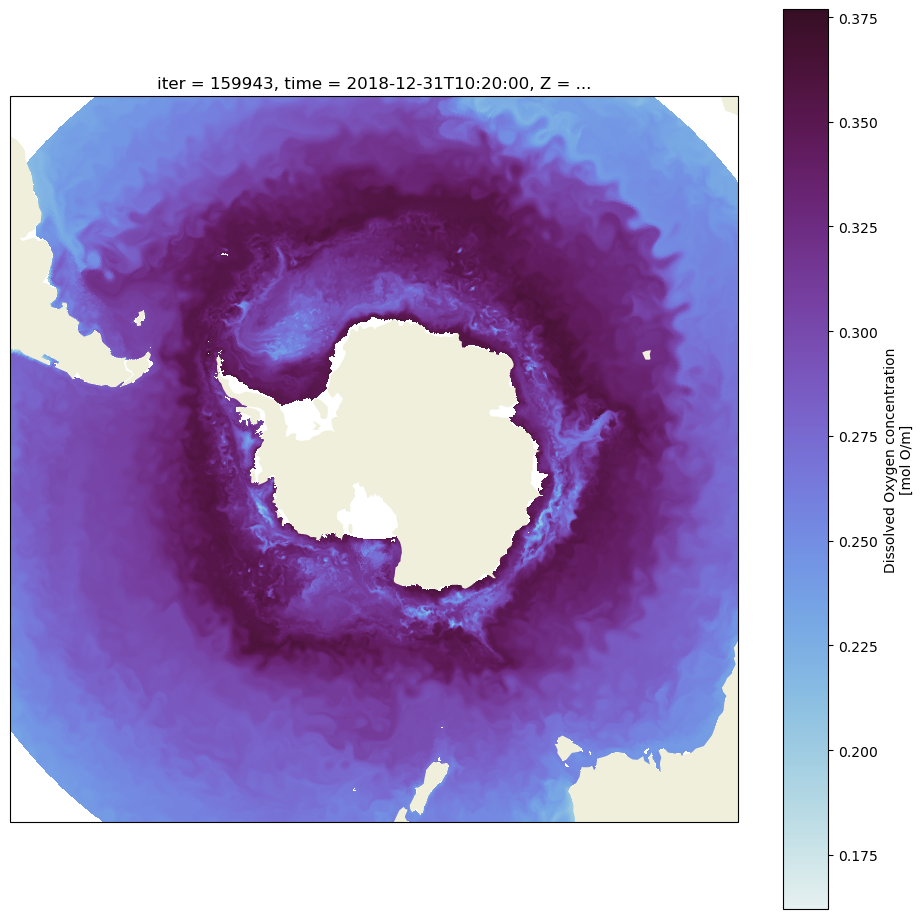

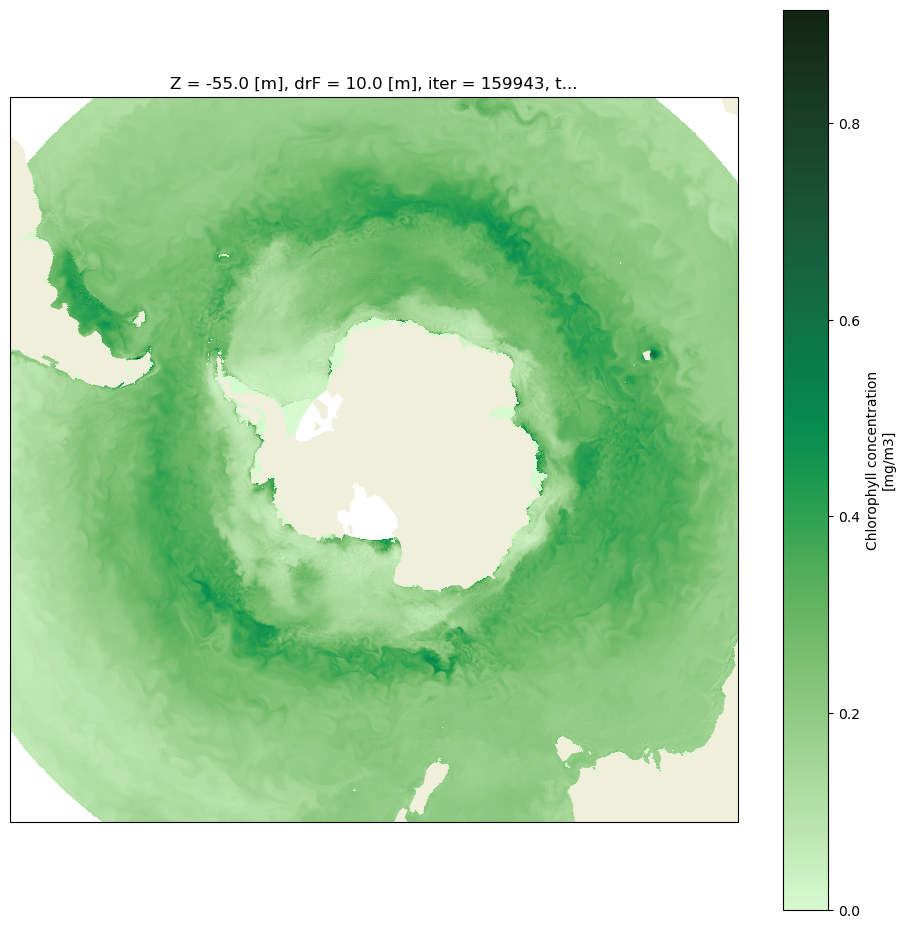

In [18]:
ax = so_ax()
temperature = xr.open_dataset('../../data/out/cnn_input_layers/sst.nc')
temperature['THETA'].plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=-5, vmax=25)
ax.add_feature(cartopy.feature.LAND, zorder=2)
ax.plot()

ax = so_ax()
sie = xr.open_dataset('../../data/out/cnn_input_layers/sea_ice_extent.nc')
sie['SIarea'].plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice)
ax.add_feature(cartopy.feature.LAND, zorder=2)
ax.plot()

ax = so_ax()
sal = xr.open_dataset('../../data/out/cnn_input_layers/salinity.nc')
sal = sal['SALT']
sal = sal.where(sal > 30)
sal.plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline)
ax.add_feature(cartopy.feature.LAND, zorder=2)
ax.plot()

ax = so_ax()
no3 = xr.open_dataset('../../data/out/cnn_input_layers/nitrate.nc')
no3 = no3['TRAC04']
no3 = no3.where(no3 > 0)
no3.plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline)
ax.add_feature(cartopy.feature.LAND, zorder=2)
ax.plot()

ax = so_ax()
o2 = xr.open_dataset('../../data/out/cnn_input_layers/oxygen.nc')
o2 = o2['TRAC03']
o2 = o2.where(o2 > 0.1)
o2.plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.dense)
ax.add_feature(cartopy.feature.LAND, zorder=2)
ax.plot()

ax = so_ax()
chl = xr.open_dataset('../../data/out/cnn_input_layers/chlorophyll.nc')
chl = chl['BLGCHL']
chl.plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.algae)
ax.add_feature(cartopy.feature.LAND, zorder=2)
ax.plot()

## Issues
### NETCDF4 to ESRI ASC file
The required data format for the MaxEnt program is an ESRI ASCII file. The data can be converted from a NetCDF file to an ESRI ASCII file with the gdal_translate command line tool
``` bash
gdal_translate -of AAIGrid -a_srs EPSG:4326 NETCDF:"oxygen.nc":TRAC03 oxygen.asc
```
After this, the ASC file needs to be edited to contain the right xllcorner and yllcorner data (default is 0,0). This can be done with a text editor. The ASC file header should look like this:
``` text
ncols        2160
nrows        588
xllcorner    -180
yllcorner    -80
cellsize     0.166666666667
NODATA_value  -9999
```
This is the header for the BSOSE data which is 588x2160 resolution. The xllcorner and yllcorner values are the longitude and latitude of the lower left corner of the data. The cellsize was calculated by $2160 * x = 360$ where 360 degrees is the latitude covered by the grid. The NODATA_value is the value that is used to represent missing data. The data values follow the header, with each row separated by a new line.

### ASC file vs training data mismatch projection
The ASC file is in the correct format and shows correct land formations, however the presence data and the environmental data are not aligned. You can see in the images below that the land masses dont match up but the points do. Some points are also missing, possibly because they overlapped with land mass at that point. <br />

Actual location of training points:
<img src="img\bacillariophyceae_correct.png" width="1570"/> 
<br /> MaxEnt output: <br />
<img src="img\bacillariophyceae_incorrect_maxent.png" width="1570"/>
